# Image Segmentation - Scene Understanding


# HW3 - Segmentation

### Come up with Story

    0. You will work in groups of three. Come up with a team name.

    1. You are given powerful segmentation model, that simulates human annotator labelling the listed classes below

    2. Come up with the interesting (specific use-case) segmentation application on the images you can produce with your phone or gather from internet

    3. State in which situation it can be used, i.e. robot navigating through terrain, catching escaped animals from zoo, safari, collecting food from table etc.

    4. It can be related to your thesis as well

### Design Model

    1. You are given MobileNetV3 as a segmentation architecture. You can use whichever you want, this is just recommended as it is running realtime on gpu and can be tested on cpu

    2. You will train the model (you can use pretrained weights on different scenes) on your collected image data

    3. Split the data to training part and testing part and validate your model on testing part in terms of IoU from Teacher and visualized outputs

    4. Specify some unique scenarios for testing and show loss values and final segmentation on these cases
        - Discuss how it fails or succeded
        - Try to explain why and what you help to improve the performance on these cases

### Things that can help you

    - Strong Regularization
        1. Weight decay in torch optimizer
        2. Data augmentation
        3. Using pretrained model
        4. More training data from unique scenarios
        5. (Advanced) self-supervised pre-training

    - Server GPUs
        1. Taylor and Cantor - ssh username@taylor.felk.cvut.cz or ssh username@cantor.felk.cvut.cz
        2. Video Tutorial in server.mp4
        3. Text guide on: https://cyber.felk.cvut.cz/cs/study/gpu-servers/

### Final Presentation

    1. Describe Idea in sheets: https://docs.google.com/spreadsheets/d/1rvsg9ZgzmXiVJsiJvnpsy-yQ7N5WqADn10NL235eC1M/edit?usp=sharing

    2. Evaluation will be given on the day of presentations - 17./18.12. based on your parralel

### Evaluation

    1. Idea and preparation of data (Unique scenarios, Useful Teacher outputs, amount of training samples)

    2. Training - loss minimization, Validity of approach, Tweaks to training (Regularizations, Augmentation, ...)

    3. Examples and output overview and discussion

    4. Discussion of training times and speed of teacher and inference model. Is it sufficiently fast for the application?

    5. Presentation clarity and enthusiasm


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import tqdm
from pathlib import Path
try:
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "Apple Roboto"
except:
    pass

%load_ext autoreload
%autoreload 3

In [2]:
dataset_name = "/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/fsoco_segmentation_processed_np_only"
dataset_dir = Path(dataset_name)
imgs_dir = dataset_dir / "img"
masks_dir = dataset_dir / "ann"

In [4]:
processed_imgs = list(imgs_dir.glob("*.npz"))
processed_masks = list(masks_dir.glob("*.npz"))
processed_imgs.sort()
processed_masks.sort()
img_mask_pairs = list(zip(processed_imgs, processed_masks))
img_mask_pairs[:5]

[(PosixPath('/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/fsoco_segmentation_processed_np_only/img/BME_00006.npz'),
  PosixPath('/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/fsoco_segmentation_processed_np_only/ann/BME_00006.npz')),
 (PosixPath('/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/fsoco_segmentation_processed_np_only/img/BME_00019.npz'),
  PosixPath('/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/fsoco_segmentation_processed_np_only/ann/BME_00019.npz')),
 (PosixPath('/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/fsoco_segmentation_processed_np_only/img/BME_00028.npz'),
  PosixPath('/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/fsoco_segmentation_processed_np_only/ann/BME_00028.npz')),
 (PosixPath('/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/fsoco_segmentation_processed_np_only/img/BME_00039.npz'),
  PosixPath('/Users/davidkorcak/Documents/ctu

# Dataset class and augmentations


In [6]:
from utils import *
from torch.utils.data import Dataset, DataLoader

tensor(0.2549) tensor(-1.) tensor(1.) tensor(0.)


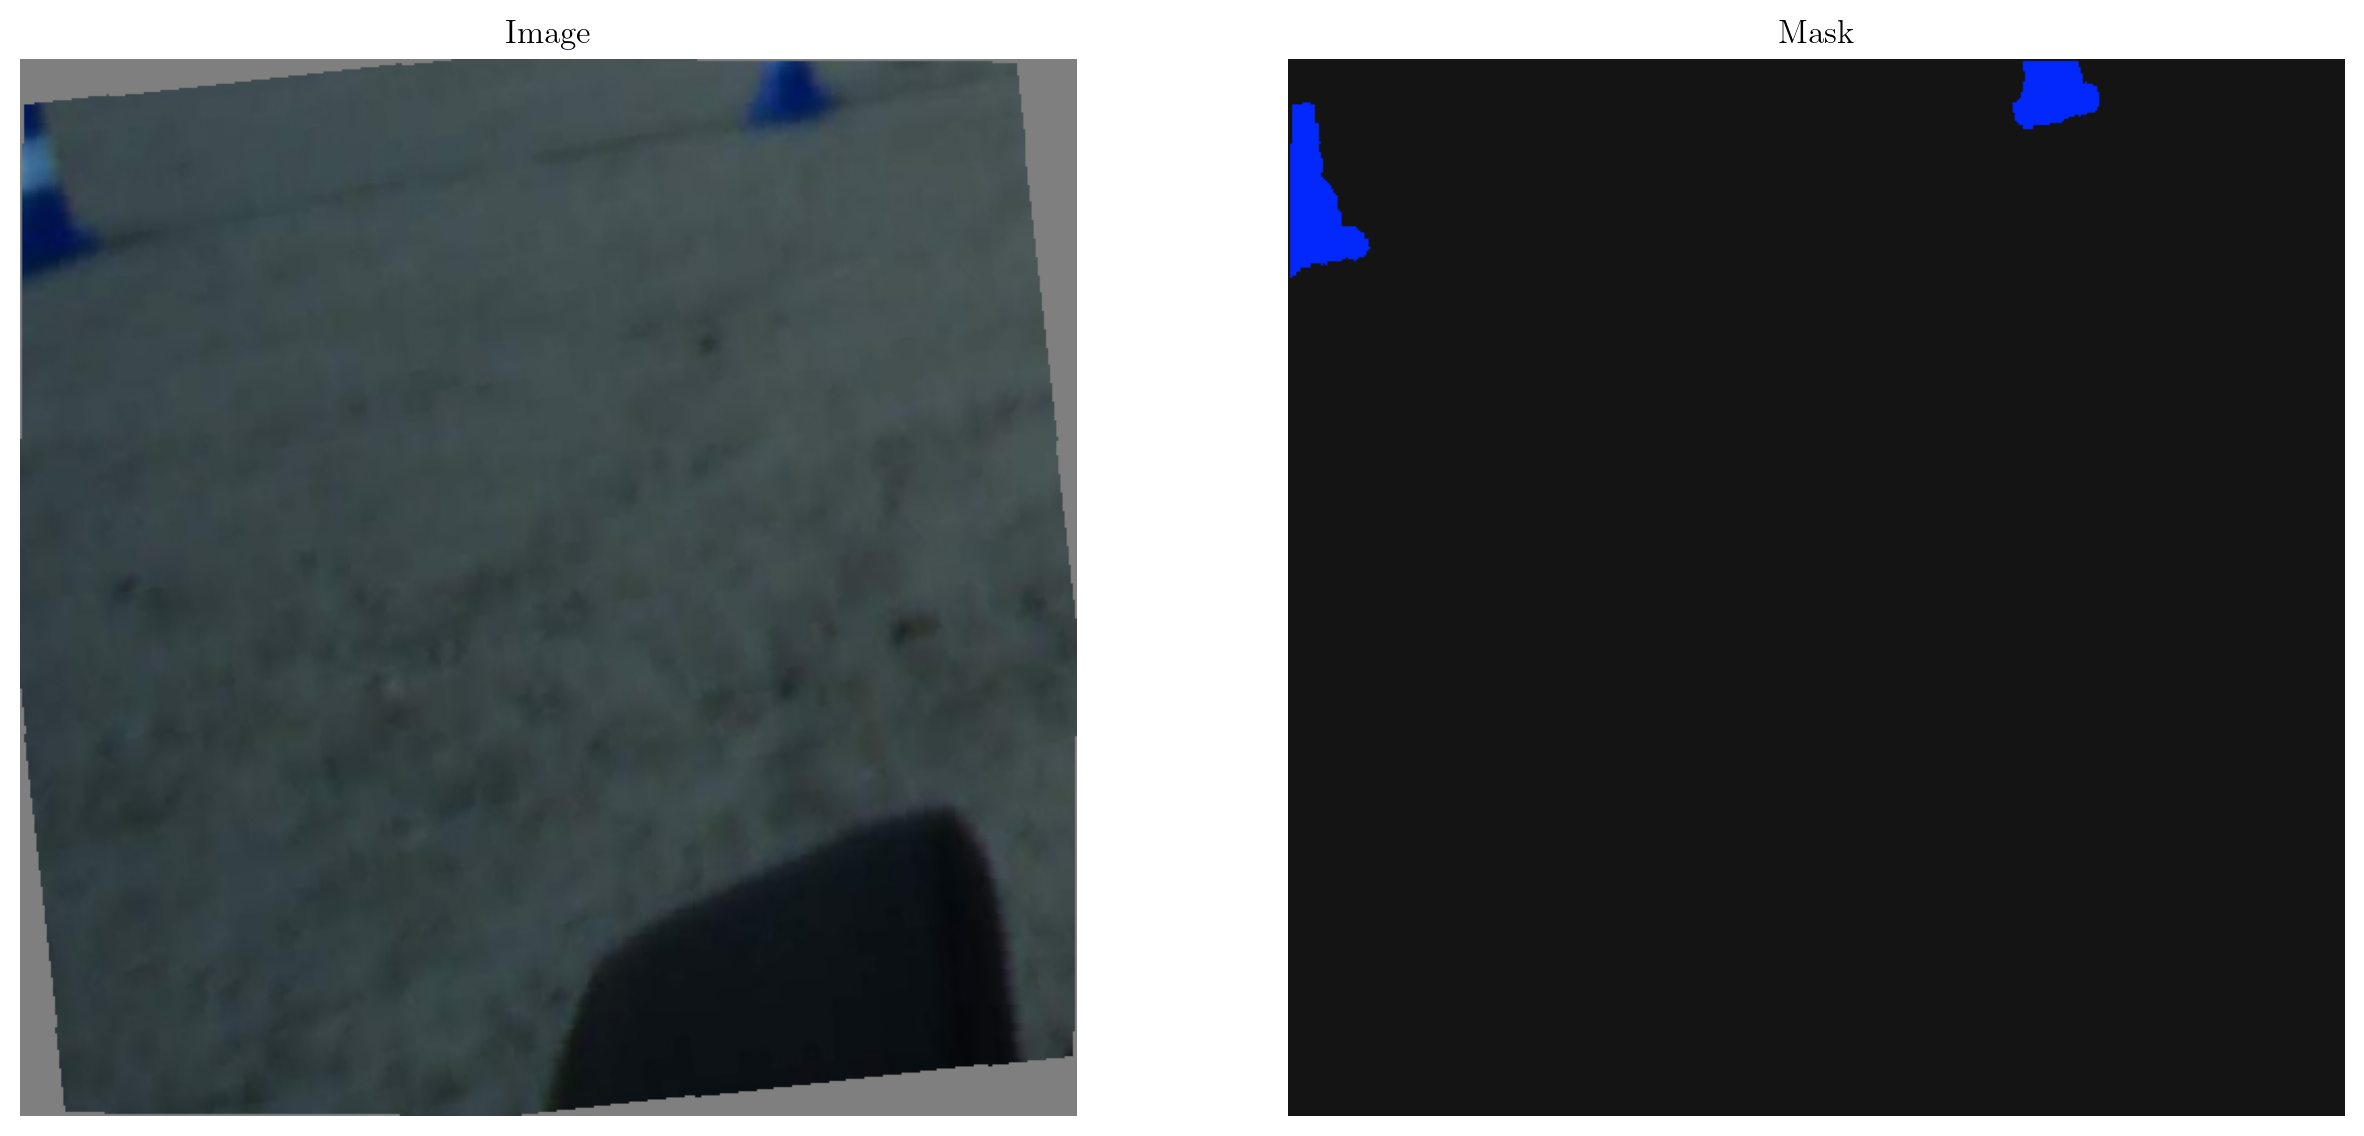

tensor(1.) tensor(-1.) tensor(1.) tensor(0.)


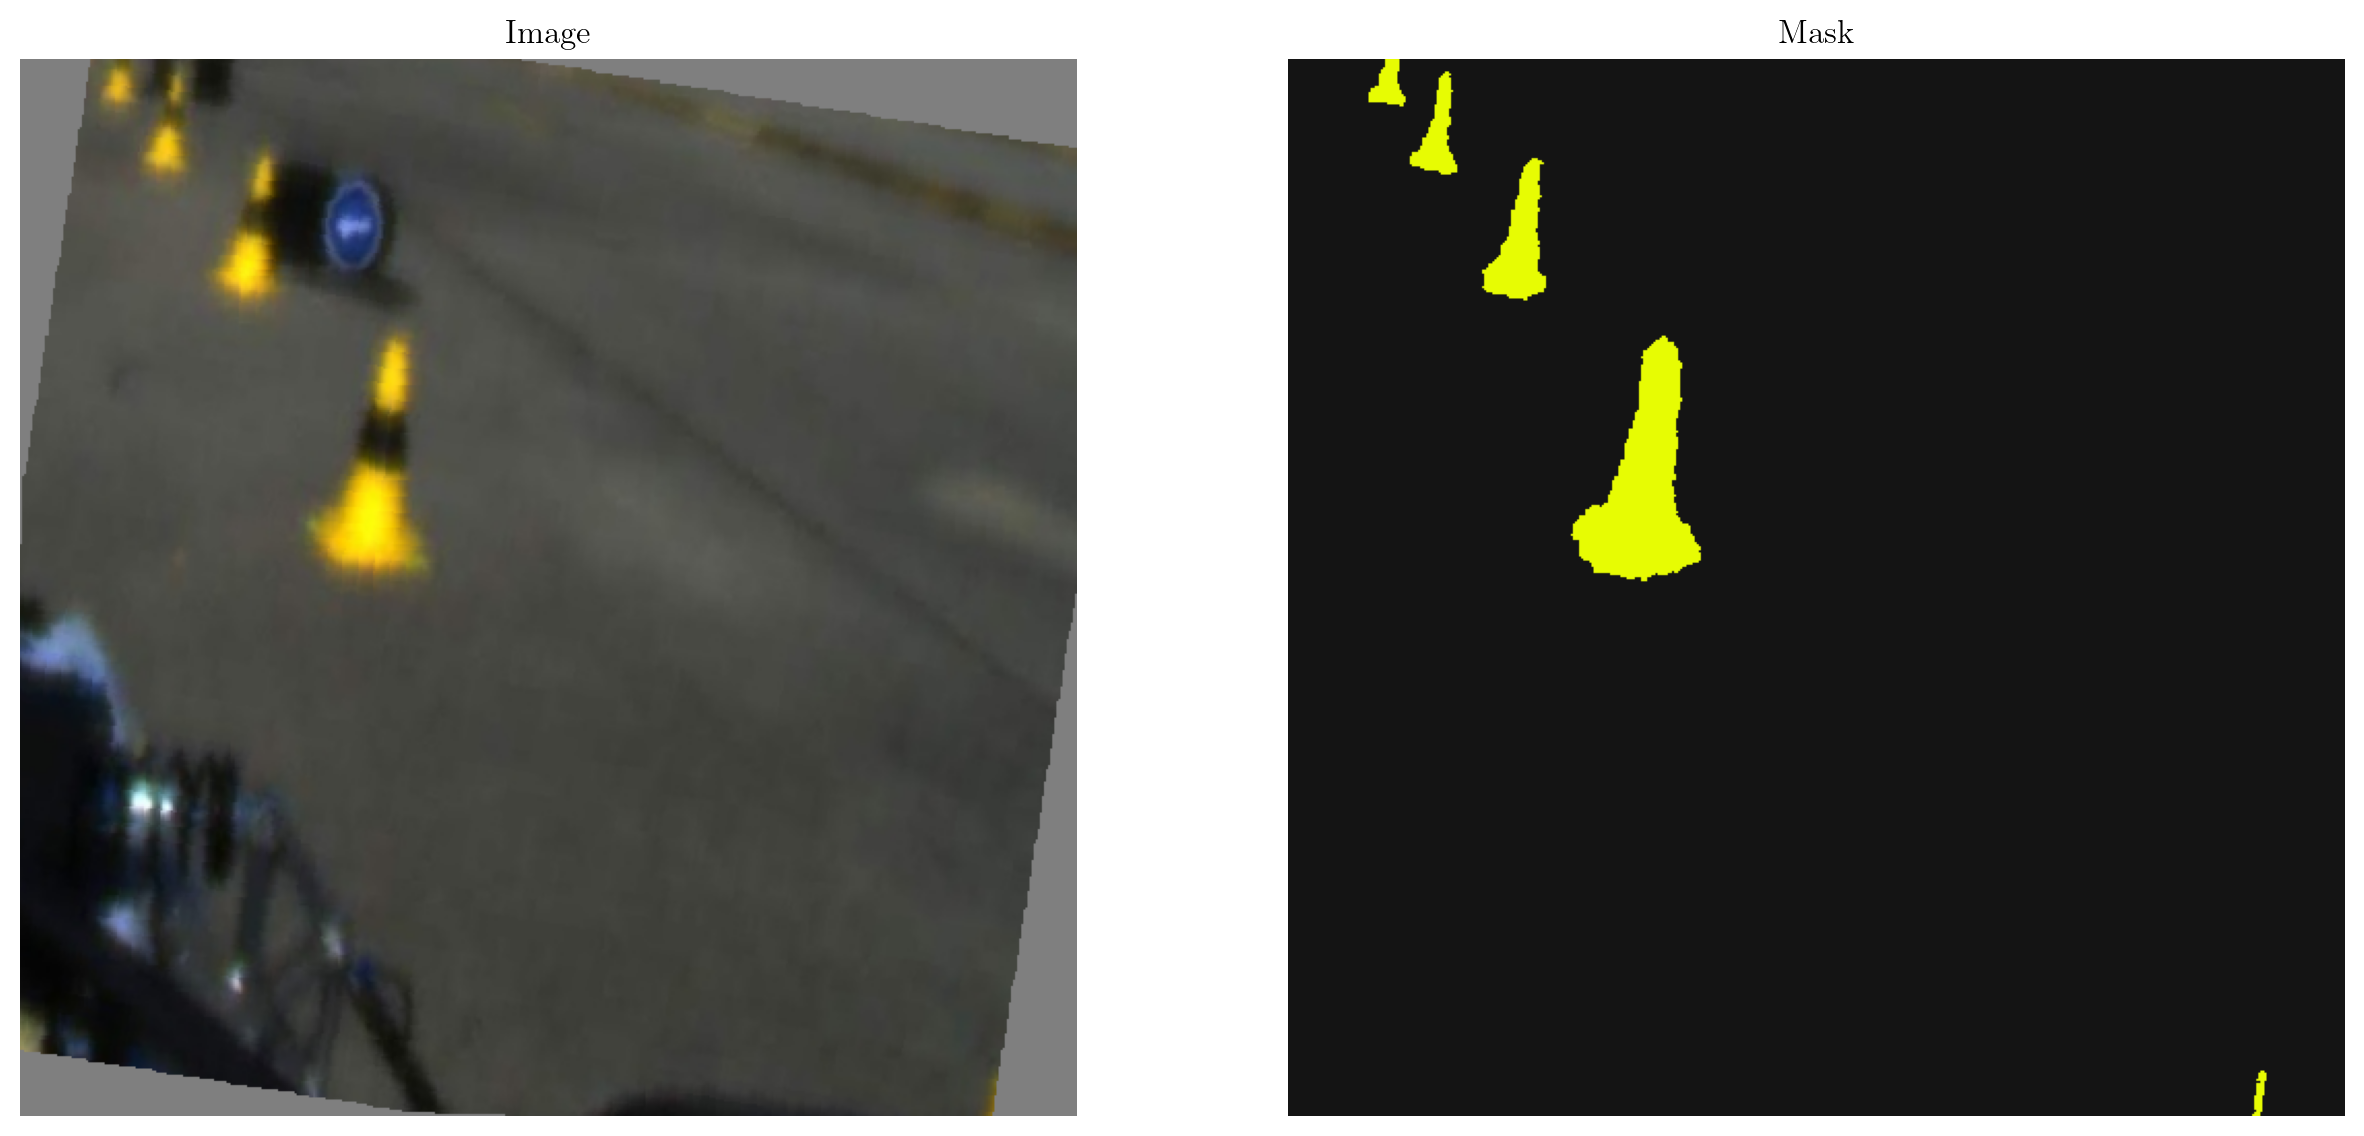

tensor(1.) tensor(-1.) tensor(1.) tensor(0.)


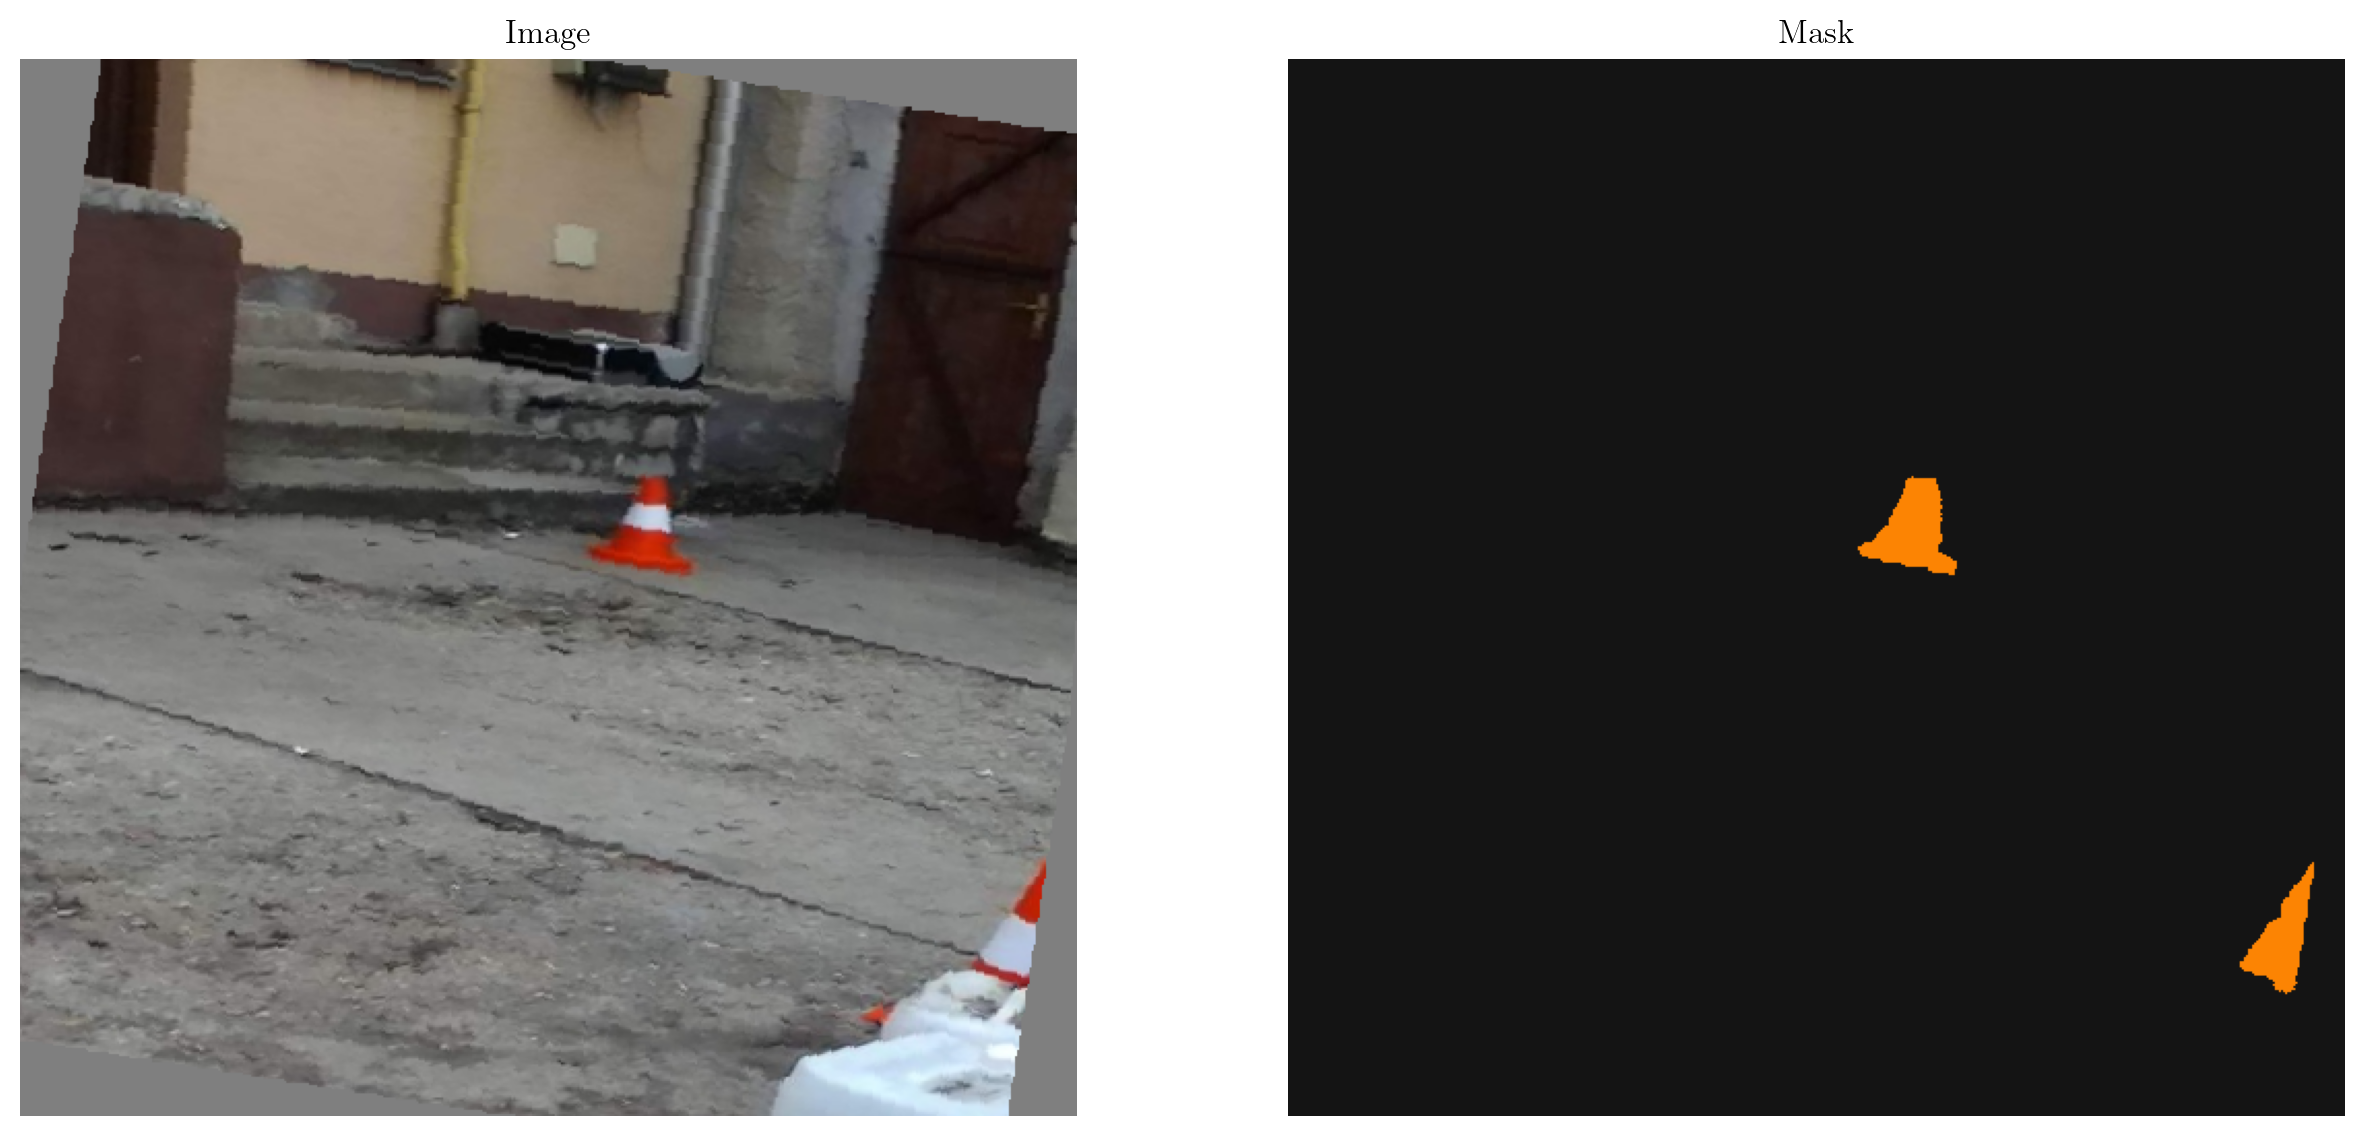

In [9]:
class_color_jitter = {
    0: {"hue": 0.5, "saturation": 0.5},
    1: {"hue": 0.5, "saturation": 0.8},
    2: {"hue": 0.5, "saturation": 0.8},
    3: {"hue": 0.5, "saturation": 0.8},
    4: {"hue": 0.5, "saturation": 0.8},
    5: {"hue": 0.5, "saturation": 0.8},
}

T = transforms.Compose(
    [
        ResizeWithMask(size=(700, 2000), antialias=True),
        RandomCropWithMask(size=(512, 512)),
        Normalize(),
        RandomHorizontalFlipWithMask(0.5),
        RandomAffineWithMask(degrees=10, translate=(0.01, 0.01)),
        RandomRotationWithMask(
            degrees=5),
        ClasswiseColorJitter(class_color_jitter)
    ])

dataset = AltConeSegmentationDataset(img_mask_pairs, transform=T)

for i in range(3):
    test_img, test_mask = dataset[i]
    print(test_img.max(), test_img.min(), test_mask.max(), test_mask.min())
    visualize_from_torch(test_img, test_mask)

In [10]:
segmask_iou(test_mask.unsqueeze(0), test_mask.unsqueeze(0))

tensor([[1., 1., 1., 1., 1., 1.]])

In [ ]:
# Torch config
torch.manual_seed(42)
np.random.seed(42)
torch.multiprocessing.set_start_method('spawn')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
# Prepare dataset splits
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Transforms for training
class_color_jitter = {
    0: {"hue": 0.5, "saturation": 0.5},
    1: {"hue": 0.5, "saturation": 0.8},
    2: {"hue": 0.5, "saturation": 0.8},
    3: {"hue": 0.5, "saturation": 0.8},
    4: {"hue": 0.5, "saturation": 0.8},
    5: {"hue": 0.5, "saturation": 0.8},
}

train_T = transforms.Compose(
    [
        ResizeWithMask(size=(700, 2000), antialias=True),
        RandomCropWithMask(size=(512, 512)),
        Normalize(),
        RandomHorizontalFlipWithMask(0.5),
        RandomAffineWithMask(degrees=10, translate=(0.01, 0.01)),
        RandomRotationWithMask(
            degrees=5),
        ClasswiseColorJitter(class_color_jitter)
    ])

eval_T = transforms.Compose([Normalize()])

#  Split img-mask pairs
train_size = int(TRAIN_SIZE * len(img_mask_pairs))
val_size = int(VAL_SIZE * len(img_mask_pairs))
test_size = len(img_mask_pairs) - train_size - val_size
train_pairs, val_pairs, test_pairs = torch.utils.data.random_split(
    img_mask_pairs, [train_size, val_size, test_size])

# Create datasets
train_set = ConeSegmentationDataset(train_pairs, transform=train_T)
val_set = ConeSegmentationDataset(val_pairs, transform=eval_T)
test_set = ConeSegmentationDataset(test_pairs, transform=eval_T)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=2,
                          shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False)
test_loader = DataLoader(test_set, batch_size=2, shuffle=False)

In [ ]:
from fastseg import MobileV3Large, MobileV3Small
# model = MobileV3Large(num_classes=6, use_aspp=True, num_filters=128)
model = MobileV3Small(num_classes=6, use_aspp=True, num_filters=128)
model = model.to(device)
CE = torch.nn.CrossEntropyLoss(reduction="none", weight=None)

In [ ]:
model.train()
EPOCHS = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
for e in range(EPOCHS):
    loop = tqdm.tqdm(train_loader)
    for x, labels in loop:
        x = x.to(device)
        labels = labels.to(device)
        output = model(x)
        loss = CE(output, labels)
        loss.mean().backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {e} loss: {loss.mean().item():.4f}")

# Saving weights
# torch.save(model.state_dict(), 'weights/model.pth')

In [ ]:
weights_path = Path('weights')
weights_path.mkdir(exist_ok=True)
torch.save(model.state_dict(), weights_path / 'model.pth')

In [ ]:
# Loading trained model
model.to("cpu")
model.load_state_dict(torch.load('weights/model.pth', map_location='cpu'))

# Setting model to eval mode
# Always test model in eval mode
model.eval()

In [ ]:
t, ty = test_set[0]
t = t.unsqueeze(0)
output = model(t)
output = output.argmax(1).squeeze().cpu().numpy()
visualize_from_torch(t.squeeze().cpu(), output)

In [ ]:
test_a = torch.rand(32, 6, 512, 512, device="mps")
test_b = torch.rand(32, 6, 512, 512, device="mps")
segmask_iou(test_a, test_b)